In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from scipy.interpolate import RegularGridInterpolator, splrep, splev
import healpy as hp
import pickle
from settings import *

# Get the detection efficiency from the public mc table

In [3]:
with open("./resources/tabulated_logE_sindec_aeff.pckl", "rb") as f:
    log_ebins, sindec_bins, aeff_i = pickle.load(f)

log_emids = calc_mids(log_ebins)
ebins = np.power(10, log_ebins)
emids = calc_mids(ebins)
ewidth = np.diff(ebins)

sindec_mids = calc_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

ra_bins = np.linspace(0, np.pi*2, num=201)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

70 log_10(energy) bins
200 declination bins


### some settings

In [4]:
# aeff in m^2
# energy in GeV
livetime = 10 * 3600 * 24 * 365.24 # 10 years in seconds
gamma_astro = -2.3
phi_astro = 1.4 * 10**(-18) # * (E/100 TeV)^gamma / GeV / sr / cm^2 / s

# just very rough estimates to get going here without MCEQ
with open("./resources/MCEq_flux.pckl", "rb") as f:
    e_grid, flux_def = pickle.load(f)
tck_numu = splrep(e_grid, np.log(flux_def['numu_conv']))
spl_vals = np.exp(splev(emids, tck_numu)) 

In [32]:
# show the public detection efficiency
def old_calculation(gamma_astro, phi_astro, livetime):
    d_public = np.genfromtxt('./resources/IC86-2012-TabulatedAeff.txt', skip_header=1)

    emin, emax = d_public[:,0], d_public[:,1]
    sindec_min, sindec_max = d_public[:,2], d_public[:,3]
    dec_min, dec_max = -np.arcsin(sindec_min), -np.arcsin(sindec_max)
    aeff = d_public[:,4]

    emin = np.unique(emin) # all lower energy bounds
    emax = np.unique(emax) # all upper energy bounds
    ebins = np.unique([emin, emax]) # all bin edges in order
    dec_min = np.unique(dec_min) # all lower dec bounds
    dec_max = np.unique(dec_max) # all upper dec bounds
    dec_bins = np.unique([dec_min, dec_max]) # all bin edges in order
    sindec_min = np.unique(sindec_min) # all lower sindec bounds
    sindec_max = np.unique(sindec_max) # all upper sindec bounds
    sindec_bins = np.unique([sindec_min, sindec_max]) # all bin edges in order
    ra_bins = np.linspace(0, np.pi*2, num=201)
    ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
    ra_width = ra_bins[1:] - ra_bins[:-1]

    aeff_2d = dict()
    aeff_2d["icecube"] = aeff.reshape(len(emin), len(dec_min)) # re-shape into 2D array with (A(E) x A(delta))

    emids = (emin + emax) / 2.
    lemids = np.power(10, (np.log10(emin) + np.log10(emax)) / 2.)
    ewidth = emax - emin
    sindec_mids = (sindec_min + sindec_max) / 2.
    sindec_width = sindec_max - sindec_min

    print(len(emids), "log_10(energy) bins")
    print(len(sindec_bins), "declination bins")
    astro_ev = ((aeff_2d["icecube"] * sindec_width).T * ewidth)* 1E4 * livetime * 2*np.pi
    astro_ev *= (emids/1E5)**(gamma_astro) * phi_astro
    print("astro events:", np.sum(astro_ev))
    
def matthias_aeff(gamma_astro, phi_astro, livetime):
    results = './resources/effective_areas_av_per_day.npy'
    loge_bins = np.linspace(2.,9.,num=25)
    e_mids = calc_mids(10**loge_bins)
    e_bins = 10**loge_bins
    sd_bins = np.linspace(-1.,1.,35)
    n_sd, n_e = len(sd_bins)-1, len(e_bins)-1
    ebin_width = np.diff(e_bins)
    print(len(emin), "log_10(energy) bins")
    print(len(dec_min), "declination bins")
    astro_ev = ((aeff_2d["icecube"] * sindec_width).T * ewidth)* 1E4 * livetime * 2*np.pi
    astro_ev *= (emids/1E5)**(gamma_astro) * phi_astro
    print("astro events:", np.sum(astro_ev))

old_calculation(gamma_astro, phi_astro, livetime)

70 log_10(energy) bins
200 declination bins
astro events: 2511.061484579241


## Galactic Center

# Dipole

Auger: "dipole with an amplitude of $6.5^{+1.3}_{−0.9}\%$ towards right ascension $\alpha_d=100\pm10$ degrees and declination $\delta_d=−24^{+12}_{−13}$ degrees"

https://arxiv.org/abs/1709.07321

### define dipole template

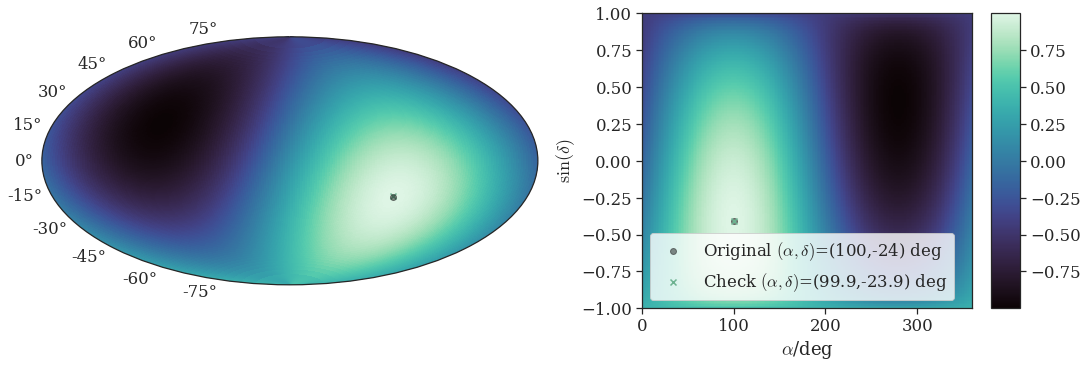

In [17]:
# coordinates from UHECR dipole https://arxiv.org/abs/1709.07321
delta_d = -24
delta_d_radian = np.deg2rad(delta_d)
alpha_d = 100
alpha_d_radian = np.deg2rad(alpha_d)
# get axes from spherical coordinates of dipole
z = np.sin(delta_d_radian)
y = np.cos(delta_d_radian) * np.sin(alpha_d_radian)
x = np.cos(delta_d_radian) * np.cos(alpha_d_radian)

# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

# get the index of the max pixel for cross check
ira, isd = np.unravel_index(dipole.argmax(), dipole.shape)

# plot with aitoff and rectangular projection for cross check
fig = plt.figure(constrained_layout=True, figsize=np.array([15, 5]))
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=[3, 2])
ax = fig.add_subplot(spec[0], projection="aitoff")
ax2 = fig.add_subplot(spec[1])

# aitoff plot with coordinate trafo
ax.pcolormesh(
    *np.meshgrid(np.pi - ra_bins, np.arcsin(sindec_bins)),
    dipole.T # transpose for plotting
)
ax.scatter(np.pi-ra_mids[ira], np.arcsin(sindec_mids[isd]), marker="x")
ax.scatter(
    np.pi - alpha_d_radian, delta_d_radian,
    marker="o",
    alpha=0.5,
    color="k"
)

# rectangular plot in RA/deg and sin(dec)
im = ax2.pcolormesh(
    *np.meshgrid(np.rad2deg(ra_bins), sindec_bins),
    dipole.T # transpose for plotting
)
plt.colorbar(im, ax=ax2, aspect=30)
# original dipole axis
ax2.scatter(
    alpha_d, np.sin(delta_d_radian),
    marker="o",
    alpha=0.5,
    color="k",
    label=r"Original $(\alpha, \delta)$=({},{}) deg".format(
        alpha_d, 
        delta_d, 
    )
)
# cross check dipole axis
ax2.scatter(
    np.rad2deg(ra_mids[ira]), sindec_mids[isd],
    marker="x", 
    label=r"Check $(\alpha, \delta)$=({:1.1f},{:1.1f}) deg".format(
        np.rad2deg(ra_mids[ira]), 
        np.rad2deg(np.arcsin(sindec_mids[isd])), 
    )
)
ax2.set_xlim(0, 360)
ax2.set_xlabel(r"$\alpha$/deg")
ax2.set_ylabel(r"$\sin(\delta)$")
ax2.legend(loc=3)

$\Lambda(data|hypothesis) = \prod_{bins\,i} \frac{\mu_i^{k_i}}{k_i!} \exp(-\mu_i)$

Signal: $\mu_i(H_1) = \mu_i^S + \mu_i^B$; defined by dipole amplitude

Background: $\mu_i(H_0) = \mu_i^B$; dipole amplitude = 0

Asimov data: $k_i = \mu_i(H_1)$

$\log(\Lambda_i) = k_i \cdot \log \mu_i - \log k_i! - \mu_i$

Test statistic: $-2\Delta LLH = -2 \left( \sum_{bins\,i} \log \Lambda_i ( H_{scan}) - \log \Lambda_i (H_{bf}) \right)$ 

# NOTE: maximum dipole amplitude is 50\%, otherwise there will be negative astro flux

* fixed dipole axis
* scan over dipole strength as free parameter
* astro normalization as additional nuisance parameter
* no systematic uncertainties
* asimov data (k_i == mu_i)

### todo:

* Flux prediction for background: atmo-nu (and atmo-mu?); MCEQ? (for now: simple E^-3.7 spectrum)
* Generate toy data -> data challenge
* Estimate systematic uncertainties -> error precision

# construct likelihood ratio test against best-fit LLH

# $-2\Delta LLH (A) = -2 \left( \log \Lambda (A)_\min - \log \Lambda_{\min, global} \right)$ 

## icecube

In [26]:
A_base = 0.065 # dipole amplitude

# baseline data for asimov data
aeff_factor = ((aeff_2d["IceCube"] * sindec_width).T * ewidth)[:,:,np.newaxis] \
              * np.atleast_2d(ra_width) * 1E4 * livetime 

# aeff_factor dimension: sindec x energy x ra
# change it now to: sindec x ra x energy
aeff_factor = np.swapaxes(aeff_factor, 1, 2)
astro_ev = np.swapaxes(aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
atm_ev = np.swapaxes(aeff_factor * spl_vals, 0, 2)
# finally: energy x ra x sindec
# define asimov data
# templates are in ra x dec
k_i = astro_ev * ((1 - A_base) * uni + A_base * dipole) + atm_ev
print("total events:", np.sum(k_i))
print("total events:", np.sum(atm_ev))
print("astro events:", np.sum(astro_ev * ((1 - A_base) * uni + A_base * dipole)))

total events: 3011932.2583677545
total events: 2998294.6619698447
astro events: 13637.596397911397


#### inwork

In [27]:
A_scaling = np.linspace(0, 0.1, num=50)
astro_scaling = np.linspace(0.92, 1.05, num=50)

# scan signal over conv and astro flux, and amplitude
llh_s = np.zeros((len(astro_scaling), len(A_scaling)))
#for k, csc in enumerate(conv_scaling):
for j, asc in enumerate(astro_scaling): 
    for i, aa in enumerate(A_scaling):
        # signal LLH of H_1
        mu_i = astro_ev * ((1 - aa) * uni + aa * dipole) * asc + atm_ev # * csc
        llh_s[j][i] = -np.sum(k_i * np.where(mu_i>0, np.log(mu_i), np.zeros_like(mu_i)) - mu_i)

astro best-fit scaling 0.9995918367346939
Amplitude best-fit 0.0653061224489796


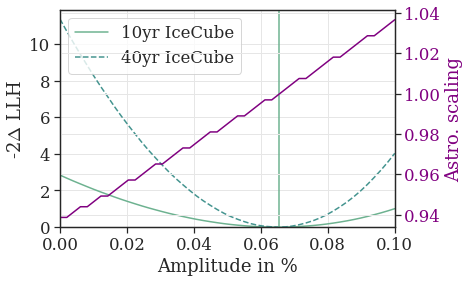

In [29]:
llh_global_min = np.min(llh_s)
llh_scan_min = np.min(llh_s, axis=0)
astro_nuis = astro_scaling[np.argmin(llh_s, axis=0)]

# index at best fit
ias, iam = np.unravel_index(llh_s.argmin(), llh_s.shape)
print("astro best-fit scaling", astro_scaling[ias])
print("Amplitude best-fit", A_scaling[iam])

f, ax = plt.subplots()
ax.plot(A_scaling, 2 * (llh_scan_min - llh_global_min), label="10yr IceCube")
ax.plot(A_scaling, 2 * (llh_scan_min - llh_global_min)*4, label="40yr IceCube", ls="--")
ax.axvline(A_scaling[iam])

# plot value of astro scaling on 2nd axis
ax2 = ax.twinx()
ax2.plot(A_scaling, astro_nuis, color="purple")
ax2.set_ylabel("Astro. scaling", color="purple")
ax2.tick_params(axis='y', labelcolor="purple")

ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))
ax.set_ylim(-0.01, np.max(2 * (llh_scan_min - llh_global_min)*4) + 0.5)
ax.grid(True)
ax.legend(loc=2)

# Ple$\nu$m

# load effective area from matthias

In [8]:
# icecube and plenum effective areas
eff_areas = np.load("./resources/effective_areas_av_per_day.npy")

ebins = np.power(10, np.linspace(2., 9., num=25))
emids = (ebins[1:] + ebins[:-1]) / 2.
ewidth = ebins[1:] - ebins[:-1]
sindec_bins = np.linspace(-1, 1, num=35)
sindec_mids = (sindec_bins[1:] + sindec_bins[:-1]) / 2.
sindec_width = sindec_bins[1:] - sindec_bins[:-1]

n_sd, n_e = len(sindec_bins)-1, len(ebins)-1

ra_bins = np.linspace(0, np.pi*2, num=51)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

# re-shape into 2D array with (A(E) x A(delta))
aeff_2d_m = dict()
aeff_2d_m["plenum"] = eff_areas['effA_plenum'].reshape((len(sindec_mids), len(emids))).T / 1E4
aeff_2d_m["icecube"] = eff_areas['effA_icecube'].reshape((len(sindec_mids), len(emids))).T / 1E4

print(np.shape(aeff_2d_m["plenum"]), "aeff shape plenum")
print(np.shape(aeff_2d_m["icecube"]), "aeff shape icecube")
print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

(24, 34) aeff shape plenum
(24, 34) aeff shape icecube
24 log_10(energy) bins
34 declination bins


### define dipole template with correct binning

In [11]:
# coordinates from UHECR dipole https://arxiv.org/abs/1709.07321
delta_d = -24
delta_d_radian = np.deg2rad(delta_d)
alpha_d = 100
alpha_d_radian = np.deg2rad(alpha_d)
# get axes from spherical coordinates of dipole
z = np.sin(delta_d_radian)
y = np.cos(delta_d_radian) * np.sin(alpha_d_radian)
x = np.cos(delta_d_radian) * np.cos(alpha_d_radian)

# set up dipole template
dipole = np.zeros((len(ra_mids), len(sindec_mids)))
# equivalent uniform template
uni = np.ones((len(ra_mids), len(sindec_mids)))

## add "z axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * sindec_mids * z
# RA=0, dec=0, add "x axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.cos(ra_mids)[:,np.newaxis] * x
# RA=90deg, dec=0, add "y axis" component
dipole += np.ones(
    (len(ra_mids), len(sindec_mids)
    )) * np.sqrt(1 - sindec_mids**2) * np.sin(ra_mids)[:,np.newaxis] * y

astro best-fit scaling 0.9995918367346939
Amplitude best-fit 0.06442953020134229
astro best-fit scaling 0.9995918367346939
Amplitude best-fit 0.06442953020134229


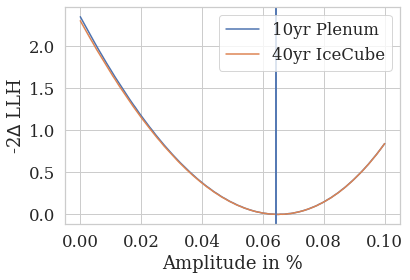

In [15]:
f, ax = plt.subplots()

for det in aeff_2d_m:
    # baseline data for asimov data
    aeff_factor = ((aeff_2d_m[det] * sindec_width).T * ewidth)[:,:,np.newaxis] * np.atleast_2d(ra_width) * 1E4 * livetime
    # aeff_factor dimension: sindec x energy x ra
    # change it now to: sindec x ra x energy
    aeff_factor = np.swapaxes(aeff_factor, 1, 2)
    astro_ev = np.swapaxes(aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
    atm_ev = np.swapaxes(aeff_factor * (emids/1E5)**(gamma_atm) * phi_atm, 0, 2)
    # finally: energy x ra x sindec
    # define asimov data
    # templates are in ra x dec
    k_i = astro_ev * ((1 - A_base) * uni + A_base * dipole) + atm_ev

    A_scaling = np.linspace(0, 0.1, num=150)
    astro_scaling = np.linspace(0.92, 1.05, num=50)

    # scan signal over conv and astro flux, and amplitude
    llh_s = np.zeros((len(astro_scaling), len(A_scaling)))
    for j, asc in enumerate(astro_scaling): 
        for i, aa in enumerate(A_scaling):
            # signal LLH of H_1
            mu_i = astro_ev * ((1 - aa) * uni + aa * dipole) * asc + atm_ev
            llh_s[j][i] = -np.sum(k_i * np.where(mu_i>0, np.log(mu_i), np.zeros_like(mu_i)) - mu_i)

    llh_global_min = np.min(llh_s)
    llh_scan_min = np.min(llh_s, axis=0)
    astro_nuis = astro_scaling[np.argmin(llh_s, axis=0)]

    # index at best fit
    ias, iam = np.unravel_index(llh_s.argmin(), llh_s.shape)
    print("astro best-fit scaling", astro_scaling[ias])
    print("Amplitude best-fit", A_scaling[iam])

    if det=="icecube":
        livetime_factor = 4
        label = "40yr IceCube"
    else:
        livetime_factor = 1
        label = "10yr Plenum"
    ax.plot(A_scaling, 2 * (llh_scan_min - llh_global_min) * livetime_factor, label=label)
    ax.axvline(A_scaling[iam])
    ax.set_xlabel("Amplitude in %")
    ax.set_ylabel(r"-2$\Delta$ LLH")
    
    ## plot value of astro scaling on 2nd axis
    #ax2 = ax.twinx()
    #ax2.plot(A_scaling, astro_nuis, color="teal")
    #ax2.set_ylabel("Astro. scaling", color="teal")
    #ax2.tick_params(axis='y', labelcolor="teal")
    #ax.set_xlim(np.min(A_scaling), np.max(A_scaling))
    #ax.set_ylim(-0.01, np.max(2 * (llh_scan_min - llh_global_min)*4) + 0.5)
    
ax.grid(True)
ax.legend(loc=0)

## what amplitude could be visible?

In [27]:
all_llh_s = []
astro_scaling = np.linspace(0.9, 1.1, num=50)
A_test = [0.065, 0.1, 0.15]

for i,A in enumerate(A_test):
    A_scaling = np.linspace(0, A + 0.1, num=150)
    all_llh_s.append(dict())
    for det in aeff_2d_m:
        # baseline data for asimov data
        aeff_factor = ((aeff_2d_m[det] * sindec_width).T * ewidth)[:,:,np.newaxis] * np.atleast_2d(ra_width) * 1E4 * livetime
        # aeff_factor dimension: sindec x energy x ra
        # change it now to: sindec x ra x energy
        aeff_factor = np.swapaxes(aeff_factor, 1, 2)
        astro_ev = np.swapaxes(aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
        atm_ev = np.swapaxes(aeff_factor * (emids/1E5)**(gamma_atm) * phi_atm, 0, 2)
        # finally: energy x ra x sindec
        # define asimov data
        # templates are in ra x dec
        k_i = astro_ev * ((1 - A) * uni + A * dipole) + atm_ev

        # scan signal over conv and astro flux, and amplitude
        llh_s = np.zeros((len(astro_scaling), len(A_scaling)))
        for j, asc in enumerate(astro_scaling): 
            for i, aa in enumerate(A_scaling):
                # signal LLH of H_1
                mu_i = astro_ev * ((1 - aa) * uni + aa * dipole) * asc + atm_ev
                llh_s[j][i] = -np.sum(k_i * np.where(mu_i>0, np.log(mu_i), np.zeros_like(mu_i)) - mu_i)
        all_llh_s[-1][det] = llh_s

astro best-fit scaling 1.0020408163265306
Amplitude best-fit 0.06644295302013424
astro best-fit scaling 1.0020408163265306
Amplitude best-fit 0.06644295302013424
astro best-fit scaling 1.0020408163265306
Amplitude best-fit 0.10067114093959732
astro best-fit scaling 1.0020408163265306
Amplitude best-fit 0.10067114093959732
astro best-fit scaling 1.0020408163265306
Amplitude best-fit 0.15100671140939598
astro best-fit scaling 1.0020408163265306
Amplitude best-fit 0.15100671140939598


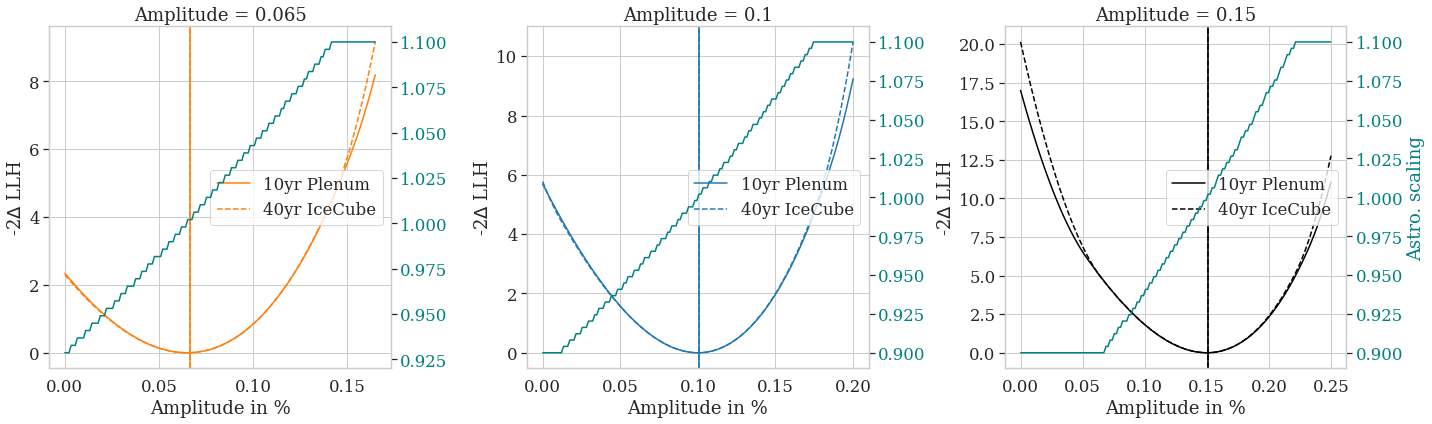

In [36]:
f, axes = plt.subplots(ncols=3, figsize=(20, 6))
colors = ["tab:orange", "tab:blue", "black"]
ls = {"icecube": "--", "plenum": "-"}

for i,A in enumerate(A_test):
    A_scaling = np.linspace(0, A + 0.1, num=150)
    for det in aeff_2d_m:
        llh_s = all_llh_s[i][det]
        llh_global_min = np.min(llh_s)
        llh_scan_min = np.min(llh_s, axis=0)
        astro_nuis = astro_scaling[np.argmin(llh_s, axis=0)]

        # index at best fit
        ias, iam = np.unravel_index(llh_s.argmin(), llh_s.shape)
        print("astro best-fit scaling", astro_scaling[ias])
        print("Amplitude best-fit", A_scaling[iam])

        if det=="icecube":
            livetime_factor = 4
            label = f"40yr IceCube"
        else:
            livetime_factor = 1
            label = f"10yr Plenum"
        axes[i].plot(
            A_scaling, 2 * (llh_scan_min - llh_global_min) * livetime_factor, label=label, color=colors[i], ls=ls[det]
        )
        axes[i].axvline(
            A_scaling[iam], color=colors[i], ls=ls[det]
        )
        axes[i].set_xlabel(
            "Amplitude in %"
        )
        axes[i].set_title(f"Amplitude = {A}")


    ## plot value of astro scaling on 2nd axis
    ax2 = axes[i].twinx()
    ax2.plot(A_scaling, astro_nuis, color="teal")
    ax2.tick_params(axis='y', labelcolor="teal")
    axes[i].grid(True)
    axes[i].legend(loc=5)
    axes[i].set_ylabel(
        r"-2$\Delta$ LLH"
    )

ax2.set_ylabel("Astro. scaling", color="teal")
f.tight_layout()

# own Ple$\nu$m calculation

# Get the detection efficiency from the public mc table

In [45]:
# show the public detection efficiency 
d_public = np.genfromtxt('./resources/IC86-2012-TabulatedAeff.txt', skip_header=1)

emin, emax = d_public[:,0], d_public[:,1]
sindec_min, sindec_max = d_public[:,2], d_public[:,3]
dec_min, dec_max = -np.arcsin(sindec_min), -np.arcsin(sindec_max)
aeff = d_public[:,4]

emin = np.unique(emin) # all lower energy bounds
emax = np.unique(emax) # all upper energy bounds
ebins = np.unique([emin, emax]) # all bin edges in order
dec_min = np.unique(dec_min) # all lower dec bounds
dec_max = np.unique(dec_max) # all upper dec bounds
dec_bins = np.unique([dec_min, dec_max]) # all bin edges in order
sindec_min = np.unique(sindec_min) # all lower sindec bounds
sindec_max = np.unique(sindec_max) # all upper sindec bounds
sindec_bins = np.unique([sindec_min, sindec_max]) # all bin edges in order
ra_bins = np.linspace(0, np.pi*2, num=201)
ra_mids = (ra_bins[1:] + ra_bins[:-1]) * 0.5
ra_width = ra_bins[1:] - ra_bins[:-1]

aeff_2d = dict()
aeff_2d["icecube"] = aeff.reshape(len(emin), len(dec_min)) # re-shape into 2D array with (A(E) x A(delta))

emids = (emin + emax) / 2.
lemids = np.power(10, (np.log10(emin) + np.log10(emax)) / 2.)
ewidth = emax - emin
sindec_mids = (sindec_min + sindec_max) / 2.
sindec_width = sindec_max - sindec_min

print(len(emin), "log_10(energy) bins")
print(len(dec_min), "declination bins")

70 log_10(energy) bins
200 declination bins


### make plenum effective area

In [46]:
# example: KM3Net
coords = { # ra # dec
    'IceCube': {"lon": 0*u.deg, "lat": -90*u.deg},
    'P-ONE': {"lon": -123.3656*u.deg, "lat": 48.4284*u.deg},
    'KM3NeT': {"lon": (16 + 6/60)*u.deg, "lat": (36 + 16/60)*u.deg},
    'Baikal-GVD': {"lon": 108.1650*u.deg, "lat": 53.5587*u.deg}
}

## Idea: transform the integration over R.A. per sin(dec) into local coordinates

In [87]:
# R.A. binning
ra_bins = np.linspace(0, np.pi * 2, num=151)
ra_mids = calc_mids(ra_bins)
ra_width = np.ones_like(ra_mids) * (ra_mids[1] - ra_mids[0])

# Interpolated grid of the effective area in "local" coordinates (= icecube's native coordinates)
grid2d = [RegularGridInterpolator(
    (np.arcsin(sindec_mids), ra_mids), # transform dec to local theta
    aeff_2d["icecube"][i][::-1,np.newaxis] * np.ones((1, len(ra_width))) / (2*np.pi), # correctly normalize new dimension
    method='linear',
    bounds_error=False,
    fill_value=0.
) for i in range(len(emids))]
# grid elements are calculated for each energy bin, grid is theta x phi

# coordinate grid in equatorial coordinates (icrs)
# these will be the integration coordinates
pp, tt = np.meshgrid(ra_mids, np.arcsin(sindec_mids))
eq_coords = SkyCoord(
    pp * u.radian,
    tt * u.radian,
    frame="icrs"
)

aeff_i = {}
# loop over detectors
for k, coord in coords.items():
    print(k)
    # local detector
    loc = EarthLocation(
        lat=coord["lat"],
        lon=coord["lon"],
    )
    # arbitrary time, doesnt matter here
    time = Time('2021-6-21 00:00:00')
    # transform integration coordinates to local frame
    local_coords = eq_coords.transform_to(AltAz(obstime=time, location=loc))
    # sum up the contributions over the transformed RA axis per declination 
    aeff_i[k] = [np.sum(
        grid2d[i]((local_coords.alt.rad, local_coords.az.rad)) * ra_width,
        axis=1) for i in range(len(emids))] # loop over the energy bins to get the same shape of aeff as before

IceCube
P-ONE
KM3NeT
Baikal-GVD


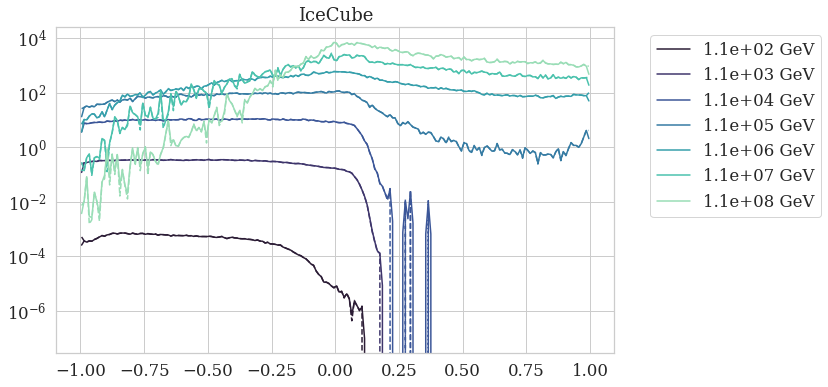

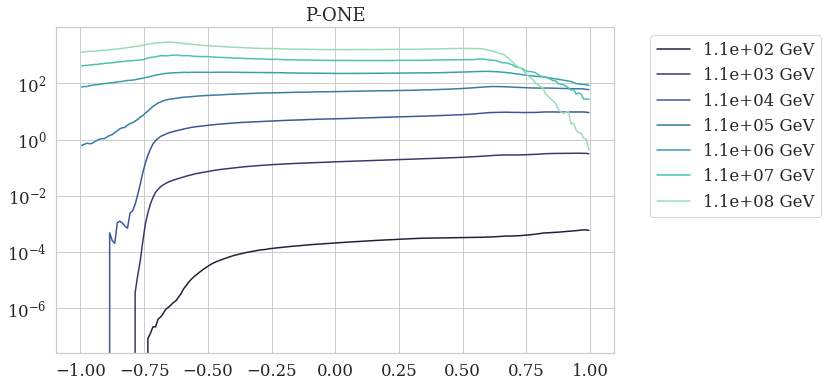

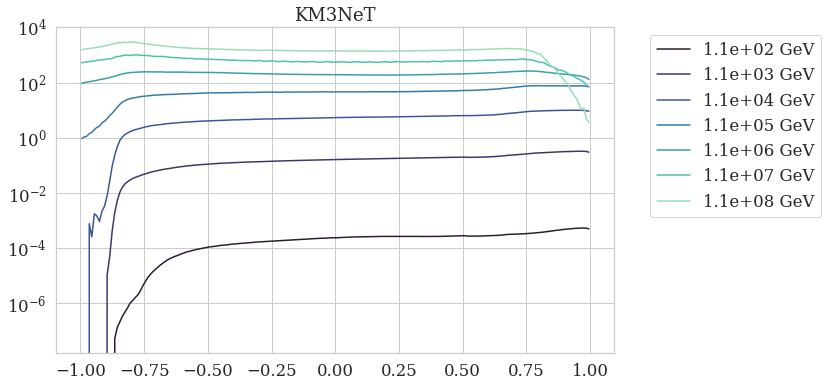

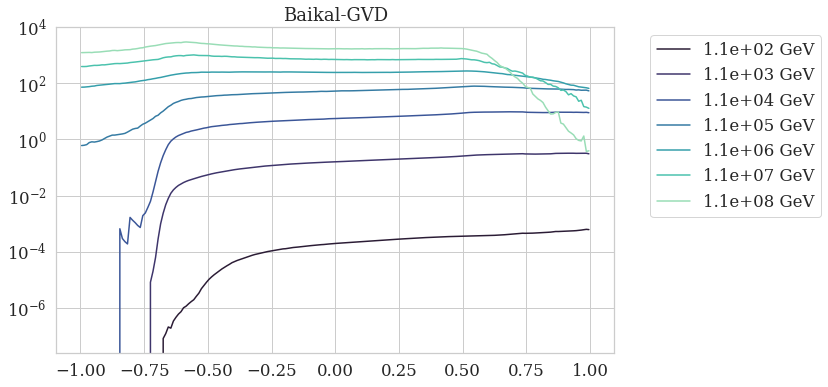

In [88]:
factor = 10
aeff_tot = np.zeros_like(aeff_i["IceCube"])
for k in aeff_i:
    aeff_tot += aeff_i[k]
    plt.figure(figsize=(10, 6))
    for ie, ae in enumerate(aeff_i[k][::factor]):
        line = plt.plot(sindec_mids, ae, label=f"{emids[ie*factor]:1.1e} GeV")
        if k=="IceCube":
            plt.plot(sindec_mids, aeff_2d["icecube"][ie*factor], ls="--", color=line[0].get_color())
    plt.yscale("log")
    plt.title(k)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)

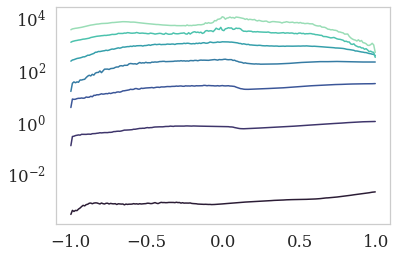

In [85]:
plt.figure()
for ae in aeff_tot[::factor]:
    plt.plot(sindec_mids[::-1], ae)
plt.yscale("log")

astro best-fit scaling 0.9995918367346939
Amplitude best-fit 0.0653061224489796


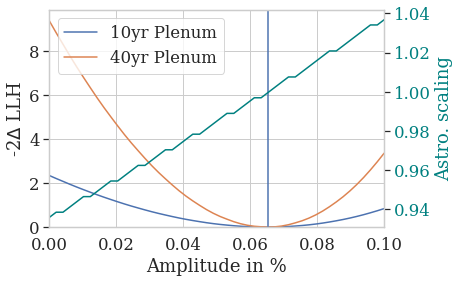

In [39]:
# aeff in m^2
# energy in GeV
livetime = 10 * 3600 * 24 * 365.24 # 10 years in seconds
gamma_astro = -2.3
phi_astro = 1.4 * 10**(-18) # * (E/100 TeV)^gamma / GeV / sr / cm^2 / s

# just very rough estimates to get going here without MCEQ
gamma_atm = -3.7
phi_atm = 2 * 10**(-18) # * (E/100 TeV)^gamma / GeV / sr / cm^2 / s

A_base = 0.065 # dipole amplitude

# baseline data for asimov data
aeff_factor = ((aeff_2d["plenum"] * sindec_width).T * ewidth)[:,:,np.newaxis] * np.atleast_2d(ra_width) * 1E4 * livetime
# aeff_factor dimension: sindec x energy x ra
# change it now to: sindec x ra x energy
aeff_factor = np.swapaxes(aeff_factor, 1, 2)
astro_ev = np.swapaxes(aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
atm_ev = np.swapaxes(aeff_factor * (emids/1E5)**(gamma_atm) * phi_atm, 0, 2)
# finally: energy x ra x sindec
# define asimov data
# templates are in ra x dec
k_i = astro_ev * ((1 - A_base) * uni + A_base * dipole) + atm_ev

A_scaling = np.linspace(0, 0.1, num=50)
astro_scaling = np.linspace(0.92, 1.05, num=50)

# scan signal over conv and astro flux, and amplitude
llh_s = np.zeros((len(astro_scaling), len(A_scaling)))
#for k, csc in enumerate(conv_scaling):
for j, asc in enumerate(astro_scaling): 
    for i, aa in enumerate(A_scaling):
        # signal LLH of H_1
        mu_i = astro_ev * ((1 - aa) * uni + aa * dipole) * asc + atm_ev # * csc
        llh_s[j][i] = -np.sum(k_i * np.where(mu_i>0, np.log(mu_i), np.zeros_like(mu_i)) - mu_i)

llh_global_min = np.min(llh_s)
llh_scan_min = np.min(llh_s, axis=0)
astro_nuis = astro_scaling[np.argmin(llh_s, axis=0)]

# index at best fit
ias, iam = np.unravel_index(llh_s.argmin(), llh_s.shape)
print("astro best-fit scaling", astro_scaling[ias])
print("Amplitude best-fit", A_scaling[iam])

f, ax = plt.subplots()
ax.plot(A_scaling, 2 * (llh_scan_min - llh_global_min), label="10yr Plenum")
ax.plot(A_scaling, 2 * (llh_scan_min - llh_global_min)*4, label="40yr Plenum")
ax.axvline(A_scaling[iam])

# plot value of astro scaling on 2nd axis
ax2 = ax.twinx()
ax2.plot(A_scaling, astro_nuis, color="teal")
ax2.set_ylabel("Astro. scaling", color="teal")
ax2.tick_params(axis='y', labelcolor="teal")

ax.set_xlabel("Amplitude in %")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))
ax.set_ylim(-0.01, np.max(2 * (llh_scan_min - llh_global_min)*4) + 0.5)
ax.grid(True)
ax.legend(loc=2)

# Other tests

## test with fixed astro scaling

In [9]:
# aeff in m^2
# energy in GeV
livetime = 10 * 3600 * 24 * 365.24 # 10 years in seconds
gamma_astro = -2.3
phi_astro = 1.4 * 10**(-18) # * (E/100 TeV)^gamma / GeV / sr / cm^2 / s

# just very rough estimates to get going here without MCEQ
gamma_atm = -3.7
phi_atm = 2 * 10**(-18) # * (E/100 TeV)^gamma / GeV / sr / cm^2 / s

A_base = 0.065 # dipole amplitude

# baseline data for asimov data
aeff_factor = ((aeff_2d * sindec_width).T * ewidth)[:,:,np.newaxis] * np.atleast_2d(ra_width) * 1E4 * livetime
# aeff_factor dimension: sindec x energy x ra
# change it now to: sindec x ra x energy
aeff_factor = np.swapaxes(aeff_factor, 1, 2)
astro_ev = np.swapaxes(aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
atm_ev = np.swapaxes(aeff_factor * (emids/1E5)**(gamma_atm) * phi_atm, 0, 2)
# finally: energy x ra x sindec
# define asimov data
# templates are in ra x dec
k_i = astro_ev * ((1 - A_base) * uni + A_base * dipole) + atm_ev

A_scaling = np.linspace(0, 0.1, num=50)

# scan signal over conv and astro flux, and amplitude
llh_s = np.zeros(len(A_scaling))
for i, aa in enumerate(A_scaling):
    # signal LLH of H_1
    mu_i = astro_ev * ((1 - aa) * uni + aa * dipole) + atm_ev
    llh_s[i] = -np.sum(k_i * np.where(mu_i>0, np.log(mu_i), np.zeros_like(mu_i)) - mu_i)

<ipython-input-9-ca1a142dd44d>:32: RuntimeWarning: divide by zero encountered in log
  llh_s[i] = -np.sum(k_i * np.where(mu_i>0, np.log(mu_i), np.zeros_like(mu_i)) - mu_i)


### construct likelihood ratio test against best-fit LLH

$-2\Delta LLH (A) = -2 \left( \log \Lambda (A)_\min - \log \Lambda_{\min, global} \right)$ 

Amplitude best-fit 0.0653061224489796


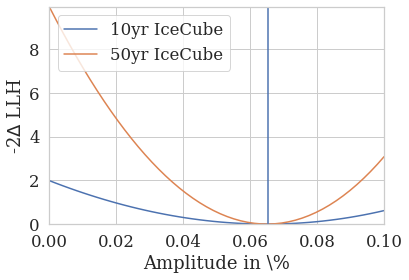

In [11]:
llh_global_min = np.min(llh_s)
print("Amplitude best-fit", A_scaling[np.argmin(llh_s)])

f, ax = plt.subplots()
ax.plot(A_scaling, 2 * (llh_s - llh_global_min), label="10yr IceCube")
ax.plot(A_scaling, 2 * (llh_s - llh_global_min)*5, label="50yr IceCube")
ax.axvline(A_scaling[np.argmin(llh_s)])

ax.set_xlabel("Amplitude in \%")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))
ax.set_ylim(-0.01, np.max(2 * (llh_s - llh_global_min)*5))
ax.grid(True)
ax.legend(loc=2)

# test without conv. component

In [12]:
# aeff in m^2
# energy in GeV
livetime = 10 * 3600 * 24 * 365.24 # 10 years in seconds
gamma_astro = -2.3
phi_astro = 1.4 * 10**(-18) # * (E/100 TeV)^gamma / GeV / sr / cm^2 / s

A_base = 0.065 # dipole amplitude

# baseline data for asimov data
aeff_factor = ((aeff_2d * sindec_width).T * ewidth)[:,:,np.newaxis] * np.atleast_2d(ra_width) * 1E4 * livetime
# aeff_factor dimension: sindec x energy x ra
# change it now to: sindec x ra x energy
aeff_factor = np.swapaxes(aeff_factor, 1, 2)
astro_ev = np.swapaxes(aeff_factor * (emids/1E5)**(gamma_astro) * phi_astro, 0, 2)
# finally: energy x ra x sindec
# define asimov data
# templates are in ra x dec
k_i = astro_ev * ((1 - A_base) * uni + A_base * dipole)

A_scaling = np.linspace(0, 0.1, num=50)
astro_scaling = np.linspace(0.92, 1.05, num=50)

# scan signal over conv and astro flux, and amplitude
llh_s = np.zeros((len(astro_scaling), len(A_scaling)))
#for k, csc in enumerate(conv_scaling):
for j, asc in enumerate(astro_scaling): 
    for i, aa in enumerate(A_scaling):
        # signal LLH of H_1
        mu_i = astro_ev * ((1 - aa) * uni + aa * dipole) * asc
        llh_s[j][i] = -np.sum(k_i * np.where(mu_i>0, np.log(mu_i), np.zeros_like(mu_i)) - mu_i)

<ipython-input-12-091bc9673c0a>:30: RuntimeWarning: divide by zero encountered in log
  llh_s[j][i] = -np.sum(k_i * np.where(mu_i>0, np.log(mu_i), np.zeros_like(mu_i)) - mu_i)


### construct likelihood ratio test against best-fit LLH

$-2\Delta LLH (A) = -2 \left( \log \Lambda (A)_\min - \log \Lambda_{\min, global} \right)$ 

astro best-fit scaling 0.9995918367346939
Amplitude best-fit 0.0653061224489796


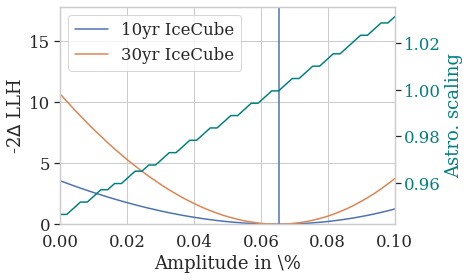

In [13]:
llh_global_min = np.min(llh_s)
llh_scan_min = np.min(llh_s, axis=0)
astro_nuis = astro_scaling[np.argmin(llh_s, axis=0)]

# index at best fit
ias, iam = np.unravel_index(llh_s.argmin(), llh_s.shape)
print("astro best-fit scaling", astro_scaling[ias])
print("Amplitude best-fit", A_scaling[iam])

f, ax = plt.subplots()
ax.plot(A_scaling, 2 * (llh_scan_min - llh_global_min), label="10yr IceCube")
ax.plot(A_scaling, 2 * (llh_scan_min - llh_global_min)*3, label="30yr IceCube")
ax.axvline(A_scaling[iam])

# plot value of astro scaling on 2nd axis
ax2 = ax.twinx()
ax2.plot(A_scaling, astro_nuis, color="teal")
ax2.set_ylabel("Astro. scaling", color="teal")
ax2.tick_params(axis='y', labelcolor="teal")

ax.set_xlabel("Amplitude in \%")
ax.set_ylabel(r"-2$\Delta$ LLH")
ax.set_xlim(np.min(A_scaling), np.max(A_scaling))
ax.set_ylim(-0.01, np.max(2 * (llh_scan_min - llh_global_min)*5))
ax.grid(True)
ax.legend(loc=2)

### stuff

rate $R= \Phi_0 \cdot \int_{-1}^{1}\,d\sin(\delta)\, (\int_{E_0}^{E_{max}} A_{\rm eff}(\delta, E) \cdot  (E/E_{ref})^{-\gamma} \, dE) $

### Visualization of the different likelihood parts
# currently not working